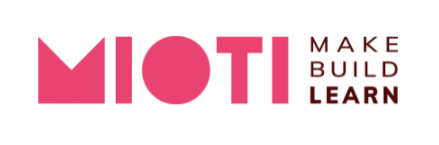

# Como usar Data Science para invertir en Bolsa

## Demostración Creación de un Algo Trader

Librerias que tenemos que instalar para el correcto funcionamiento del notebook.

In [1]:
!pip install -U pandas_datareader tqdm tensorflow

In [50]:
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader as data_reader
from tqdm import tqdm_notebook as tqdm
from tqdm.keras import TqdmCallback
%matplotlib inline
import mplfinance as mpf
import tensorflow as tf

## 1.2 Crear el Dataset

Definimos una función que utilizando la librería `pandas_datareader` descargaremos de yahoo las cotizaciones de los activos que queremos modelizar.

In [51]:
def dataset_loader(stock_name,start_date=None,end_date=None):
  
    dataset = data_reader.DataReader(stock_name, 
                                   data_source="yahoo",
                                   start=start_date,
                                   end=end_date)
    return dataset

Hacemos una prueba cargando el valor de una acción (en este caso APPLE cuyo id es AAPL)

In [91]:
#stock='BBVA'
#stock='IBM'
#stock='TSLA'
stock='GOOGL'
#stock='AMZN'
#stock='WMT'
#stock='TEF'
df=dataset_loader(stock,start_date='2015-01-01')
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-01-02,535.799988,527.880005,532.599976,529.549988,1324000,529.549988
2015-01-05,527.989990,517.750000,527.150024,519.460022,2059100,519.460022
2015-01-06,521.210022,505.549988,520.500000,506.640015,2722800,506.640015
2015-01-07,511.489990,503.649994,510.950012,505.149994,2345900,505.149994
2015-01-08,507.500000,495.019989,501.510010,506.910004,3652700,506.910004
...,...,...,...,...,...,...
2021-11-18,3011.610107,2957.689941,2964.830078,2996.770020,1780400,2996.770020
2021-11-19,3019.330078,2977.979980,2999.510010,2978.530029,1684100,2978.530029
2021-11-22,2996.590088,2922.949951,2986.649902,2926.040039,1529700,2926.040039


Calculo la variación del previo de la acción vs el día anterior.

In [92]:
df['price_ratio']=df['Adj Close']/df['Adj Close'].shift(1)

<AxesSubplot:xlabel='Date'>

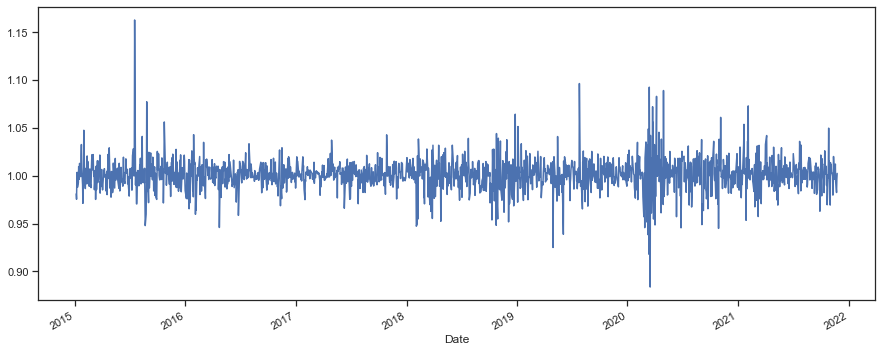

In [93]:
df['price_ratio'].plot(figsize=(15,6))

In [94]:
df.loc[df['price_ratio'].isna(),'price_ratio']=1
df['cum_price']=df['price_ratio'].cumprod()

In [95]:
df

,High,Low,Open,Close,Volume,Adj Close,price_ratio,cum_price
Date,,,,,,,,
2015-01-02,535.799988,527.880005,532.599976,529.549988,1324000,529.549988,1.000000,1.000000
2015-01-05,527.989990,517.750000,527.150024,519.460022,2059100,519.460022,0.980946,0.980946
2015-01-06,521.210022,505.549988,520.500000,506.640015,2722800,506.640015,0.975321,0.956737
2015-01-07,511.489990,503.649994,510.950012,505.149994,2345900,505.149994,0.997059,0.953923
2015-01-08,507.500000,495.019989,501.510010,506.910004,3652700,506.910004,1.003484,0.957247
...,...,...,...,...,...,...,...,...
2021-11-18,3011.610107,2957.689941,2964.830078,2996.770020,1780400,2996.770020,1.012101,5.659088
2021-11-19,3019.330078,2977.979980,2999.510010,2978.530029,1684100,2978.530029,0.993913,5.624644
2021-11-22,2996.590088,2922.949951,2986.649902,2926.040039,1529700,2926.040039,0.982377,5.525522


Date
2015-01-02    1.000000
2021-11-24    5.518648
Name: cum_price, dtype: float64

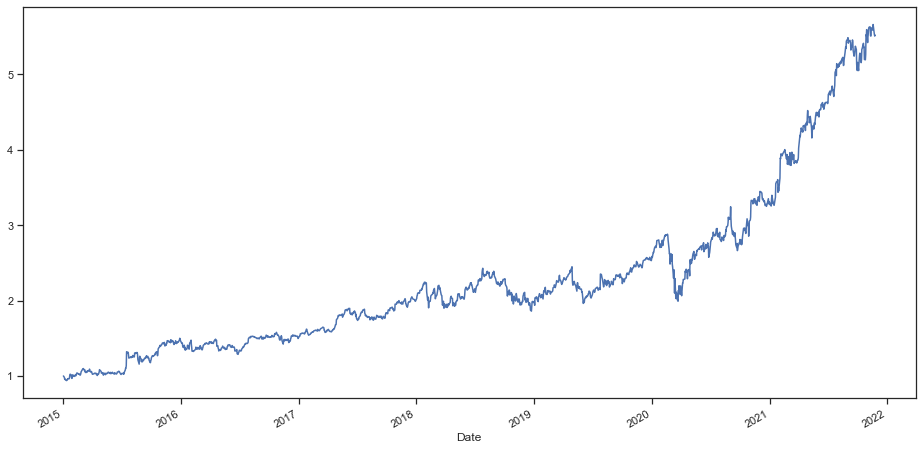

In [96]:
df['cum_price'].plot(figsize=(16,8));
df['cum_price'][[0,-1]]

Ahora voy a calcular las variaciones de precio de los 5 días anteriores para introducirlas en un modelo y el volumen de los 5 días anteriores

In [97]:
df['price_ratio1']=df['price_ratio'].shift(1)
df['price_ratio2']=df['price_ratio'].shift(2)
df['price_ratio3']=df['price_ratio'].shift(3)
df['price_ratio4']=df['price_ratio'].shift(4)
df['price_ratio5']=df['price_ratio'].shift(5)
df['price_ratio6']=df['price_ratio'].shift(6)
df['price_ratio7']=df['price_ratio'].shift(7)


In [98]:
df.head(10)

,High,Low,Open,Close,Volume,Adj Close,price_ratio,cum_price,price_ratio1,price_ratio2,price_ratio3,price_ratio4,price_ratio5,price_ratio6,price_ratio7
Date,,,,,,,,,,,,,,,
2015-01-02,535.799988,527.880005,532.599976,529.549988,1324000,529.549988,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-05,527.989990,517.750000,527.150024,519.460022,2059100,519.460022,0.980946,0.980946,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-06,521.210022,505.549988,520.500000,506.640015,2722800,506.640015,0.975321,0.956737,0.980946,1.000000,NaN,NaN,NaN,NaN,NaN
2015-01-07,511.489990,503.649994,510.950012,505.149994,2345900,505.149994,0.997059,0.953923,0.975321,0.980946,1.000000,NaN,NaN,NaN,NaN
2015-01-08,507.500000,495.019989,501.510010,506.910004,3652700,506.910004,1.003484,0.957247,0.997059,0.975321,0.980946,1.000000,NaN,NaN,NaN
2015-01-09,508.600006,498.649994,508.179993,500.720001,2100000,500.720001,0.987789,0.945558,1.003484,0.997059,0.975321,0.980946,1.000000,NaN,NaN
2015-01-12,500.279999,490.910004,499.239990,497.059998,2856900,497.059998,0.992691,0.938646,0.987789,1.003484,0.997059,0.975321,0.980946,1.000000,NaN
2015-01-13,508.600006,497.260010,502.570007,501.799988,3047900,501.799988,1.009536,0.947597,0.992691,0.987789,1.003484,0.997059,0.975321,0.980946,1.000000
2015-01-14,508.260010,498.160004,500.420013,505.929993,2640000,505.929993,1.008230,0.955396,1.009536,0.992691,0.987789,1.003484,0.997059,0.975321,0.980946


In [99]:
# Borramos todos los registros que tengan algún valor NaN
df.dropna(inplace=True)

In [100]:
# 0: Vender
# 1: Mantener
# 2: Comprar

df['comprar']=[0 if (x-1)<-0.0075 else 2 if (x-1)>0.0075 else 1 for x in df['price_ratio']]


In [101]:
df.head(10)

,High,Low,Open,Close,Volume,Adj Close,price_ratio,cum_price,price_ratio1,price_ratio2,price_ratio3,price_ratio4,price_ratio5,price_ratio6,price_ratio7,comprar
Date,,,,,,,,,,,,,,,,
2015-01-13,508.600006,497.260010,502.570007,501.799988,3047900,501.799988,1.009536,0.947597,0.992691,0.987789,1.003484,0.997059,0.975321,0.980946,1.000000,2
2015-01-14,508.260010,498.160004,500.420013,505.929993,2640000,505.929993,1.008230,0.955396,1.009536,0.992691,0.987789,1.003484,0.997059,0.975321,0.980946,2
2015-01-15,509.750000,502.010010,508.890015,504.010010,2553400,504.010010,0.996205,0.951770,1.008230,1.009536,0.992691,0.987789,1.003484,0.997059,0.975321,1
2015-01-16,510.850006,503.089996,503.149994,510.459991,2482900,510.459991,1.012797,0.963951,0.996205,1.008230,1.009536,0.992691,0.987789,1.003484,0.997059,2
2015-01-20,515.609985,509.369995,512.770020,509.940002,2339800,509.940002,0.998981,0.962969,1.012797,0.996205,1.008230,1.009536,0.992691,0.987789,1.003484,1
2015-01-21,521.849976,509.589996,510.839996,520.390015,2317800,520.390015,1.020493,0.982702,0.998981,1.012797,0.996205,1.008230,1.009536,0.992691,0.987789,2
2015-01-22,538.840027,521.909973,523.000000,537.299988,2803400,537.299988,1.032495,1.014635,1.020493,0.998981,1.012797,0.996205,1.008230,1.009536,0.992691,2
2015-01-23,545.409973,535.750000,538.030029,541.950012,2298300,541.950012,1.008654,1.023416,1.032495,1.020493,0.998981,1.012797,0.996205,1.008230,1.009536,2
2015-01-26,541.500000,532.070007,541.500000,536.719971,1546600,536.719971,0.990350,1.013540,1.008654,1.032495,1.020493,0.998981,1.012797,0.996205,1.008230,0


In [102]:
variables_X=['price_ratio1',
              'price_ratio2',
              'price_ratio3',
              'price_ratio4',
              'price_ratio5',
              'price_ratio6',
              'price_ratio7']
df_X=df[variables_X]
df_y=df['comprar']             

In [103]:
scaled_features = {}
for each in variables_X:
    mean, std = df_X[each].mean(), df_X[each].std()
    scaled_features[each] = [mean, std]
    df_X.loc[:, each] = (df_X[each] - mean)/std

C:\Users\Usuario\.conda\envs\finance\lib\site-packages\pandas\core\indexing.py:1781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


In [104]:
scaled_features

{'price_ratio1': [1.0011570637000249, 0.01669946092152764],
 'price_ratio2': [1.001152062600337, 0.016702168744335083],
 'price_ratio3': [1.0011642560819263, 0.016696157684333635],
 'price_ratio4': [1.001166073277048, 0.016695539225615345],
 'price_ratio5': [1.0011448252115365, 0.016705016773517045],
 'price_ratio6': [1.0011331497653027, 0.016712069867549948],
 'price_ratio7': [1.0011353912722705, 0.016711657284210577]}

In [105]:
df_X

,price_ratio1,price_ratio2,price_ratio3,price_ratio4,price_ratio5,price_ratio6,price_ratio7
Date,,,,,,,
2015-01-13,-0.506995,-0.800094,0.138947,-0.245997,-1.545902,-1.207929,-0.067940
2015-01-14,0.501752,-0.506614,-0.801113,0.138843,-0.244586,-1.544551,-1.208093
2015-01-15,0.423566,0.501970,-0.507526,-0.801251,0.140036,-0.243784,-1.544723
2015-01-16,-0.296538,0.423796,0.501421,-0.507654,-0.799525,0.140676,-0.243924
2015-01-20,0.697044,-0.296190,0.423219,0.501330,-0.506094,-0.798488,0.140545
...,...,...,...,...,...,...,...
2021-11-18,-0.000043,-0.301285,-0.160775,1.126507,-0.120643,-1.283280,-0.113111
2021-11-19,0.655342,0.000257,-0.302124,-0.160890,1.127140,-0.119893,-1.283446
2021-11-22,-0.433763,0.655535,-0.000474,-0.302244,-0.159527,1.127363,-0.120030


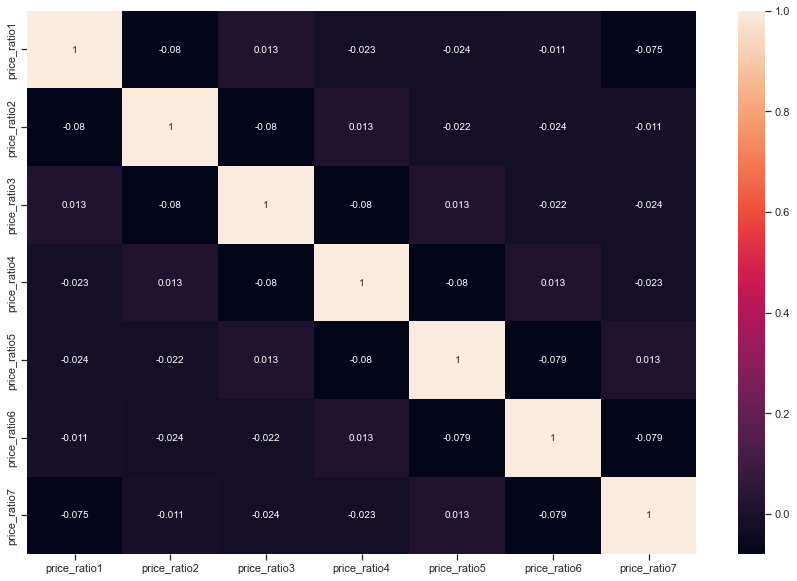

In [106]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="ticks", color_codes=True)
%matplotlib inline
plt.figure(figsize=(15, 10))
sns.heatmap(df_X.corr(),annot=True);

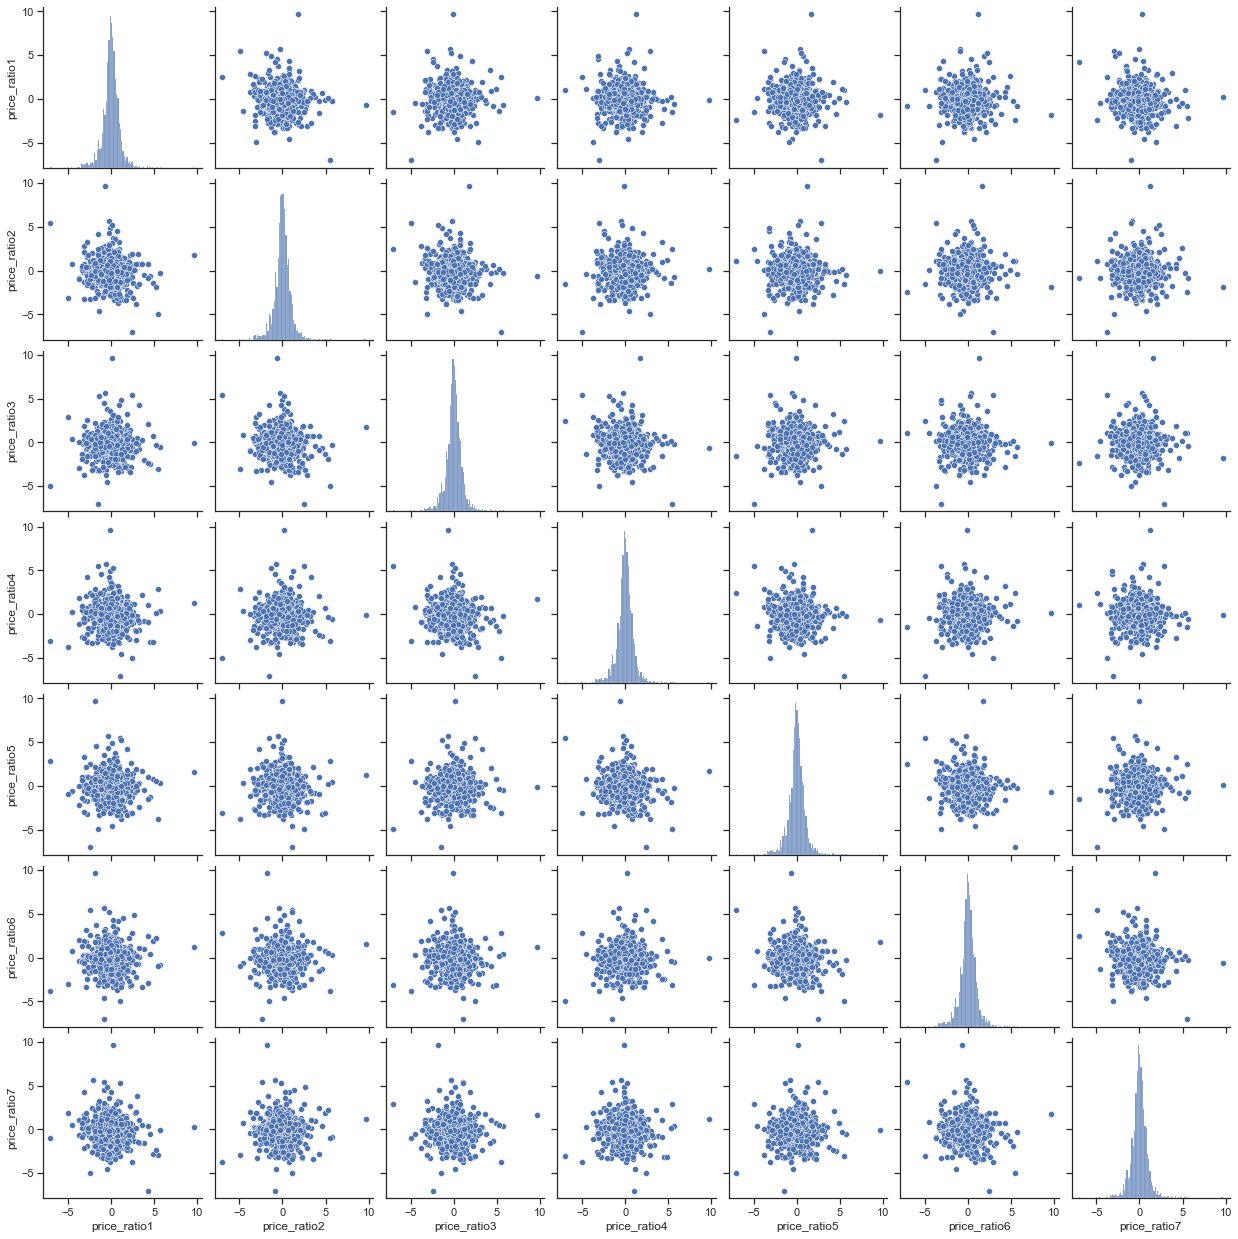

In [107]:
sns.pairplot(df_X)

<AxesSubplot:ylabel='Frequency'>

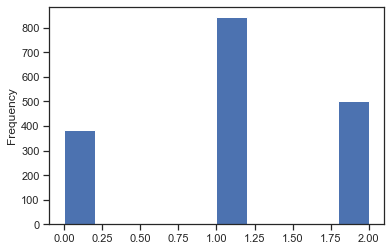

In [108]:
df_y.plot(kind='hist')

In [109]:
X_train=df_X[:-60]
X_test=df_X[-60:]
y_train=df_y[:-60]
y_test=df_y[-60:]

In [110]:
X_train

,price_ratio1,price_ratio2,price_ratio3,price_ratio4,price_ratio5,price_ratio6,price_ratio7
Date,,,,,,,
2015-01-13,-0.506995,-0.800094,0.138947,-0.245997,-1.545902,-1.207929,-0.067940
2015-01-14,0.501752,-0.506614,-0.801113,0.138843,-0.244586,-1.544551,-1.208093
2015-01-15,0.423566,0.501970,-0.507526,-0.801251,0.140036,-0.243784,-1.544723
2015-01-16,-0.296538,0.423796,0.501421,-0.507654,-0.799525,0.140676,-0.243924
2015-01-20,0.697044,-0.296190,0.423219,0.501330,-0.506094,-0.798488,0.140545
...,...,...,...,...,...,...,...
2021-08-25,0.452386,1.068965,0.702560,0.032309,-0.599647,-0.780780,0.184919
2021-08-26,0.277261,0.452612,1.068620,0.702477,0.033562,-0.598695,-0.780933
2021-08-27,-0.338397,0.277516,0.452045,1.068551,0.703350,0.034247,-0.598844


<AxesSubplot:ylabel='Frequency'>

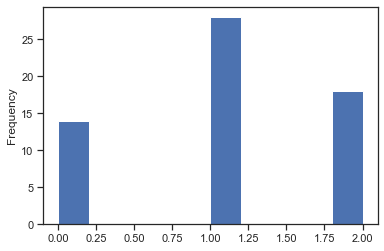

In [111]:
y_test.plot(kind='hist')

<AxesSubplot:ylabel='Frequency'>

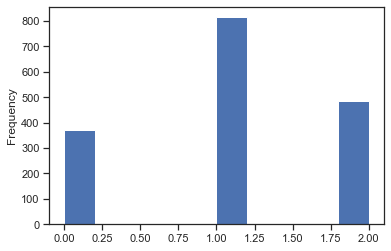

In [112]:
y_train.plot(kind='hist')

In [113]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(units=18, 
                                activation='sigmoid', 
                                input_shape=(df_X.shape[1], )))


model.add(tf.keras.layers.Dense(units=3, 
                                activation='softmax',
                                batch_size=16))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)
model.compile(optimizer=optimizer, 
              loss='sparse_categorical_crossentropy', 
              metrics=['sparse_categorical_accuracy'])


In [114]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 18)                144       
                                                                 
 dense_7 (Dense)             (None, 3)                 57        
                                                                 
Total params: 201
Trainable params: 201
Non-trainable params: 0
_________________________________________________________________


In [115]:
NUM_EPOCHS=250
history=model.fit(X_train, y_train,
                  epochs=NUM_EPOCHS,
                  callbacks=[TqdmCallback()], # coloca una barra de progreso
                  validation_split=0.15,
                  verbose=0)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

In [116]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)

2/2 [==============================] - 0s 993us/step - loss: 1.1435 - sparse_categorical_accuracy: 0.4000


In [117]:
def plotCurves(history,epochs):

    plt.plot(history.history['sparse_categorical_accuracy'],'r')
    plt.plot(history.history['val_sparse_categorical_accuracy'],'g')
    plt.xticks(np.arange(0, epochs, 50.0))
    plt.rcParams['figure.figsize'] = (8, 6)
    plt.xlabel("Num of Epochs")
    plt.ylabel("categorical_accuracy")
    plt.title("Training vs Validation Sparse Categorical Accuracy")
    plt.legend(['train','validation'])
 
    plt.show()

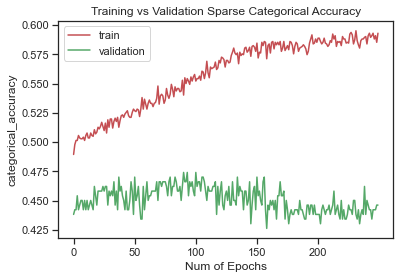

In [118]:
plotCurves(history,NUM_EPOCHS)

In [119]:
predictions = model.predict(X_test)

In [120]:
from sklearn.metrics import confusion_matrix
labels = [0,1,2]
cm=confusion_matrix(y_test.values,
                    predictions.argmax(axis=1))
cm

array([[ 0, 11,  3],
       [ 2, 16, 10],
       [ 1,  9,  8]], dtype=int64)

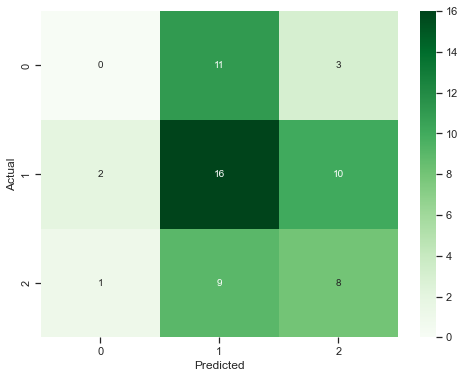

In [121]:
sns.heatmap(cm,
            annot=True,
            fmt='d',
            cmap='Greens')
plt.ylabel('Actual')
plt.xlabel('Predicted');

### Recall o true positive rate (TPR)

Porcentaje de casos positivos correctamente clasificados
$$TPR=\frac{TP}{TP+FN}$$

### Precision (PPV)

Porcentaje de realmente correctos a partir de los casos clasificados como correctos
$$PPV=\frac{TP}{TP+FP}$$

### Accuracy (ACC)

Porcentaje de predicciones correctas
$$ACC=\frac{TP+TN}{TP+TN+FP+FN}$$

### F-measure
Media armonica de TPR y PPV.

$$Fmeasure=\frac{2 \times TPR \times PPV}{TPR+PPV}$$

In [122]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score 
print(accuracy_score(y_test.values,
                    predictions.argmax(axis=1)))
print(classification_report(y_test.values,
                    predictions.argmax(axis=1)))

0.4
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        14
           1       0.44      0.57      0.50        28
           2       0.38      0.44      0.41        18

    accuracy                           0.40        60
   macro avg       0.28      0.34      0.30        60
weighted avg       0.32      0.40      0.36        60



Dibujamos la posición que el modelo nos ha dado como resultado

<AxesSubplot:xlabel='Date'>

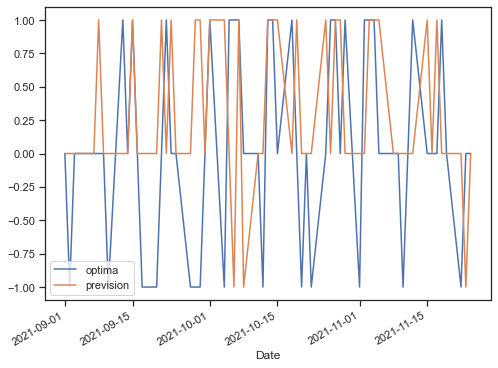

In [123]:
# Convierto la serie en un dataframe
df_y=y_test.to_frame()
# Cambio el nombre de la variable a optima
df_y.rename({'comprar':'optima'}, axis=1,inplace=True)  # new method
# Cambio los valores de la columna real a 0 mantener, 1 comprar, -1 vender
df_y['optima']= [0 if x==1 else 1 if x==2 else -1 for x in df_y['optima']]
# inserto en el DataFrame mis previsiones
df_y['prevision']=predictions.argmax(axis=1)
# Cambio los valores de la columna prevision a 0 mantener, 1 comprar, -1 vender
df_y['prevision']= [0 if x==1 else 1 if x==2 else -1 for x in df_y['prevision']]
# Dibujo las posiciones a lo largo del tiempo
df_y.plot()

In [124]:
# copio las variaciones diarias del historico
df_y['returns']=df['price_ratio']
# calculo la rentabilidad obtenida de solo mantener
df_y['cum_returns']=df_y['returns'].cumprod()

In [125]:
# calculo la rentabilidad del modelo
df_y['model_returns']=df_y['returns']*df_y['prevision']
df_y.loc[df_y['prevision'] ==-1, 'model_returns'] = df_y['model_returns']+2

In [126]:
# copio las variaciones diarias del historico
df_y['returns']=df['price_ratio']
# calculo la rentabilidad obtenida de solo mantener
df_y['cum_returns']=df_y['returns'].cumprod()
# calculo la rentabilidad del modelo
df_y['model_returns']=df_y['returns']*df_y['prevision']
df_y.loc[df_y['prevision'] ==-1, 'model_returns'] = df_y['model_returns']+2
df_y.loc[df_y['prevision'] ==0, 'model_returns'] = 1

# calculo la rentabilidad acumulada del modelo
df_y['cum_model_returns']=df_y['model_returns'].cumprod()
# calulo la rentabilidad acululada óptima
df_y['optima_returns']=df_y['returns']*df_y['optima']
df_y.loc[df_y['optima'] ==-1, 'optima_returns'] = df_y['optima_returns']+2
df_y.loc[df_y['optima'] ==0, 'optima_returns'] = 1

df_y['cum_optima_returns']=df_y['optima_returns'].cumprod()
df_y.head()

,optima,prevision,returns,cum_returns,model_returns,cum_model_returns,optima_returns,cum_optima_returns
Date,,,,,,,,
2021-09-01,0,0,1.003580,1.003580,1.000000,1.000000,1.00000,1.00000
2021-09-02,-1,0,0.986720,0.990252,1.000000,1.000000,1.01328,1.01328
2021-09-03,0,0,1.003158,0.993379,1.000000,1.000000,1.00000,1.01328
2021-09-07,0,0,1.003764,0.997118,1.000000,1.000000,1.00000,1.01328
2021-09-08,0,1,0.995914,0.993044,0.995914,0.995914,1.00000,1.01328


<AxesSubplot:xlabel='Date'>

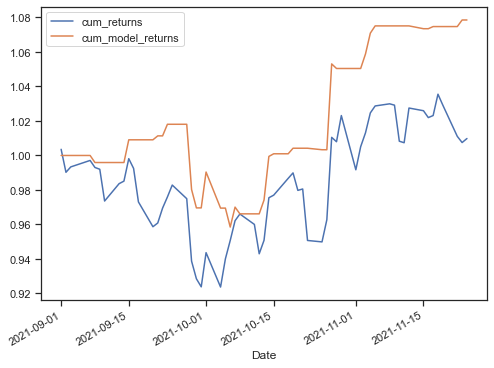

In [127]:
df_y[['cum_returns','cum_model_returns']].plot()

Costes Transacción 0.2%
            cum_returns  cum_model_returns  cum_model_returns_ct
Date                                                            
2021-11-24     1.009831           1.078559              1.027962


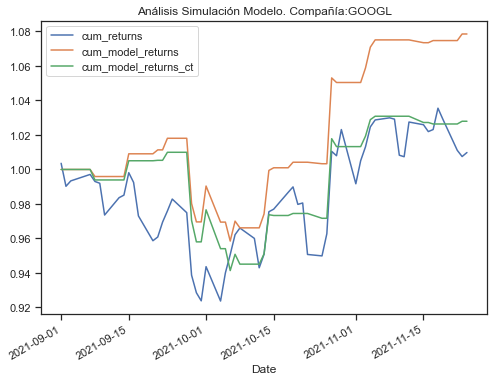

In [129]:
costes_transaccion=0.002
df_y['costes_transaccion']=np.abs(costes_transaccion*df_y['prevision'])
df_y['model_returns_ct']=df_y['model_returns']*(1-df_y['costes_transaccion'])
df_y['cum_model_returns_ct']=df_y['model_returns_ct'].cumprod()
print('Costes Transacción '+str(costes_transaccion*100)+"%")
print(df_y[['cum_returns','cum_model_returns','cum_model_returns_ct']][-1:])
chart_title='Análisis Simulación Modelo. Compañía:'+stock
df_y[['cum_returns','cum_model_returns','cum_model_returns_ct']].plot(title=chart_title);

In [ ]:
df_y[['prevision','optima']].plot(kind='hist',subplots=True)